# ScaleRunner Usage

In [1]:
# Load modules.
import sys
import os
from pathlib import Path
import scale.olm as olm

In [2]:
# Set the path.
scalerte_path=Path(os.environ.get("SCALE_DIR","/Users/Shared/ornldev/code/scale/tri14/INSTALL")) / "bin" / "scalerte"
print(scalerte_path)

/Users/Shared/ornldev/code/scale/tri14/INSTALL/bin/scalerte


In [3]:
# Create a SCALE instance.
scale_rte=olm.core.ScaleRunner(scalerte_path)
print('version:',scale_rte.version)
print('data (GB):',scale_rte.data_size/1e9)

version: 7.0.pre-b7
data (GB): 124.721543444


In [4]:
# Create a temporary directory for inputs.
ti=olm.core.TempDir()

In [5]:
# Create test input files in a temporary directory. Each input file just runs "sleep 1" to sleep
# for 1 second, but it does it through SCALE's shell command.
input_list=[]
sleep_seconds = 2
num_tasks = 10
for i in range(num_tasks):
    input_list.append(ti.write_file(f"=shell\nsleep {sleep_seconds}\nend\n",f"{i}.inp"))

In [6]:
# Run the first input.
input, output = scale_rte.run(input_list[0])
srs = output['scale_runtime_seconds']

In [7]:
# Create a thread executor.
num_workers=6
tpe = olm.core.ThreadPoolExecutor(max_workers=num_workers)

In [8]:
# Run all the inputs.
import time
start = time.time()
total_needed_seconds = srs*num_tasks
results = tpe.execute(scale_rte.run,input_list)
total_used_seconds = time.time() - start
print('ideal time:',total_needed_seconds/num_workers)
print('used time:',total_used_seconds)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.78it/s]

ideal time: 4.61853822072347
used time: 5.636963129043579


In [9]:
for k,v in results.items():
    print(k,v['success'])

/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpngtpz2d1/0.inp True
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpngtpz2d1/3.inp True
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpngtpz2d1/4.inp True
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpngtpz2d1/2.inp True
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpngtpz2d1/6.inp True
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpngtpz2d1/5.inp True
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpngtpz2d1/1.inp True
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpngtpz2d1/7.inp True
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpngtpz2d1/8.inp True
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpngtpz2d1/9.inp True


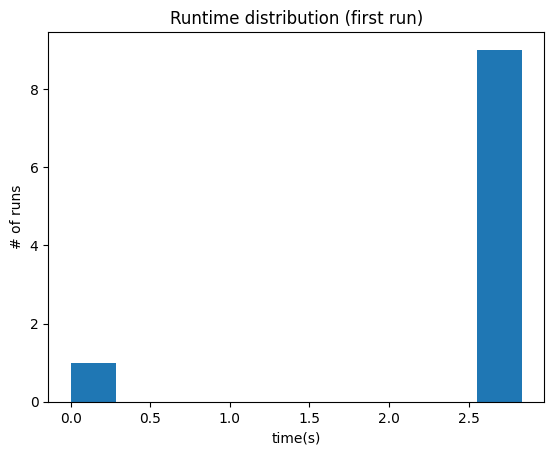

In [10]:
# Plot a histogram of runtimes.
import matplotlib.pyplot as plt
times1 = [v['runtime_seconds'] for k,v in results.items()]
plt.hist(times1,10)
plt.title('Runtime distribution (first run)')
plt.ylabel('# of runs')
plt.xlabel('time(s)')
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1859.09it/s]


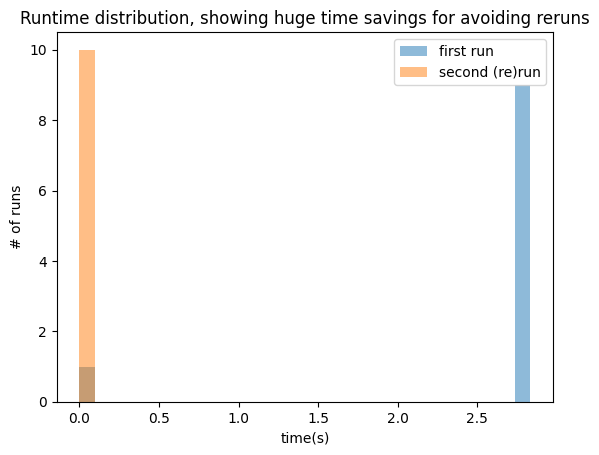

In [11]:
# Rerun an plot a histogram of runtimes.
import numpy as np
results = tpe.execute(scale_rte.run,input_list)
times2 = [v['runtime_seconds'] for k,v in results.items()]
bins = np.linspace(0, np.amax([times1,times2]), 30)
plt.hist(times1, bins, alpha=0.5, label='first run')
plt.hist(times2, bins, alpha=0.5, label='second (re)run')
plt.legend(loc='upper right')
plt.title('Runtime distribution, showing huge time savings for avoiding reruns')
plt.ylabel('# of runs')
plt.xlabel('time(s)')
plt.show()


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.17it/s]


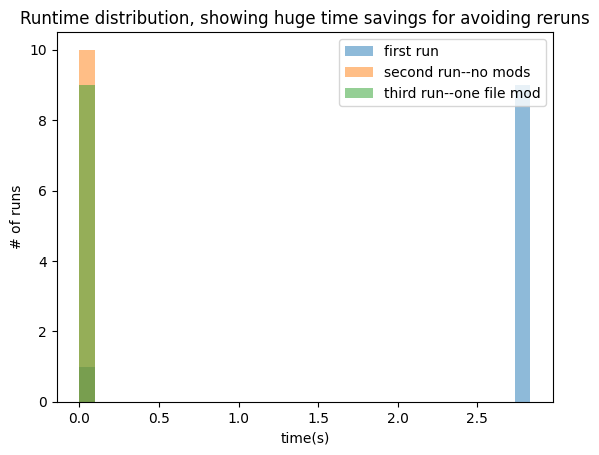

In [12]:
# Finally, if we modify a file, only that file will be rerun even when we submit the entire group.
import random
rand = random.uniform(1.0,3.0)
ti.write_file(f"=shell\nsleep {rand} \nend\n","0.inp")
results = tpe.execute(scale_rte.run,input_list)
times3 = [v['runtime_seconds'] for k,v in results.items()]
plt.hist(times1, bins, alpha=0.5, label='first run')
plt.hist(times2, bins, alpha=0.5, label='second run--no mods')
plt.hist(times3, bins, alpha=0.5, label='third run--one file mod')
plt.legend(loc='upper right')
plt.title('Runtime distribution, showing huge time savings for avoiding reruns')
plt.ylabel('# of runs')
plt.xlabel('time(s)')
plt.show()

In [13]:
for k,x in results.items():
    print(k,x['rerun'])
    if x['rerun']:
        print(k,'was rerun!')

/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpngtpz2d1/1.inp False
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpngtpz2d1/4.inp False
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpngtpz2d1/5.inp False
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpngtpz2d1/2.inp False
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpngtpz2d1/3.inp False
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpngtpz2d1/7.inp False
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpngtpz2d1/9.inp False
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpngtpz2d1/6.inp False
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpngtpz2d1/8.inp False
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpngtpz2d1/0.inp True
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmpngtpz2d1/0.inp was rerun!
